# Load and Pre-Process

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

c:\Users\pondt\anaconda3\envs\efficientnet\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
img_size = 224
batch_size = 32

train_dir = r'D:\Senior_WorkTable\GrowQuest_Data_Final\train'
val_dir = r'D:\Senior_WorkTable\GrowQuest_Data_Final\val'
test_dir = r'D:\Senior_WorkTable\GrowQuest_Data_Final\test' 

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
    )

Found 4199 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# Build Model 

In [3]:
# --- Base Model ---
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model
base_model.trainable = False

# add Early_stopping 

In [4]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_mobilenetv3_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# FineTune & Training

In [ ]:
# Unfreeze for fine-tuning
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)
# 70 Epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/70
132/132 [==============================] - ETA: 0s - loss: 4.0648 - accuracy: 0.3372 - precision: 0.3428 - recall: 0.3013
Epoch 1: val_loss improved from inf to 3.58169, saving model to best_mobilenetv3_model.h5
132/132 [==============================] - 232s 2s/step - loss: 4.0648 - accuracy: 0.3372 - precision: 0.3428 - recall: 0.3013 - val_loss: 3.5817 - val_accuracy: 0.3167 - val_precision: 0.3386 - val_recall: 0.2611 - lr: 1.0000e-05
Epoch 2/70
132/132 [==============================] - ETA: 0s - loss: 3.8373 - accuracy: 0.4172 - precision: 0.4229 - recall: 0.3737
Epoch 2: val_loss improved from 3.58169 to 3.44907, saving model to best_mobilenetv3_model.h5
132/132 [==============================] - 178s 1s/step - loss: 3.8373 - accuracy: 0.4172 - precision: 0.4229 - recall: 0.3737 - val_loss: 3.4491 - val_accuracy: 0.4156 - val_precision: 0.4205 - val_recall: 0.3378 - lr: 1.0000e-05
Epoch 3/70
132/132 [==============================] - ETA: 0s - loss: 3.6152 - accuracy:

# Load best saved model

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall

# Load best saved model from previous training
model = load_model(
    'best_mobilenetv3_model.h5',
    custom_objects={'Precision': Precision, 'Recall': Recall}
)

# Check performance directly after loading
loss, acc, prec, rec = model.evaluate(val_generator)
print(f"Restored model - val_accuracy: {acc:.4f}, val_precision: {prec:.4f}, val_recall: {rec:.4f}")


29/29 [==============================] - 40s 1s/step - loss: 1.6473 - accuracy: 0.9378 - precision: 0.9408 - recall: 0.9356
Restored model - val_accuracy: 0.9378, val_precision: 0.9408, val_recall: 0.9356


In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-6),  # lower LR for more refined training
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Continue training
history_continued = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/200
132/132 [==============================] - ETA: 0s - loss: 1.6224 - accuracy: 0.9431 - precision_1: 0.9474 - recall_1: 0.9390
Epoch 1: val_loss improved from inf to 1.64411, saving model to best_mobilenetv3_model.h5
132/132 [==============================] - 215s 2s/step - loss: 1.6224 - accuracy: 0.9431 - precision_1: 0.9474 - recall_1: 0.9390 - val_loss: 1.6441 - val_accuracy: 0.9367 - val_precision_1: 0.9407 - val_recall_1: 0.9344 - lr: 1.0000e-06
Epoch 2/200
132/132 [==============================] - ETA: 0s - loss: 1.6114 - accuracy: 0.9505 - precision_1: 0.9544 - recall_1: 0.9464
Epoch 2: val_loss improved from 1.64411 to 1.64268, saving model to best_mobilenetv3_model.h5
132/132 [==============================] - 184s 1s/step - loss: 1.6114 - accuracy: 0.9505 - precision_1: 0.9544 - recall_1: 0.9464 - val_loss: 1.6427 - val_accuracy: 0.9378 - val_precision_1: 0.9407 - val_recall_1: 0.9344 - lr: 1.0000e-06
Epoch 3/200
132/132 [==============================] - ETA: 0s

# check Graph 

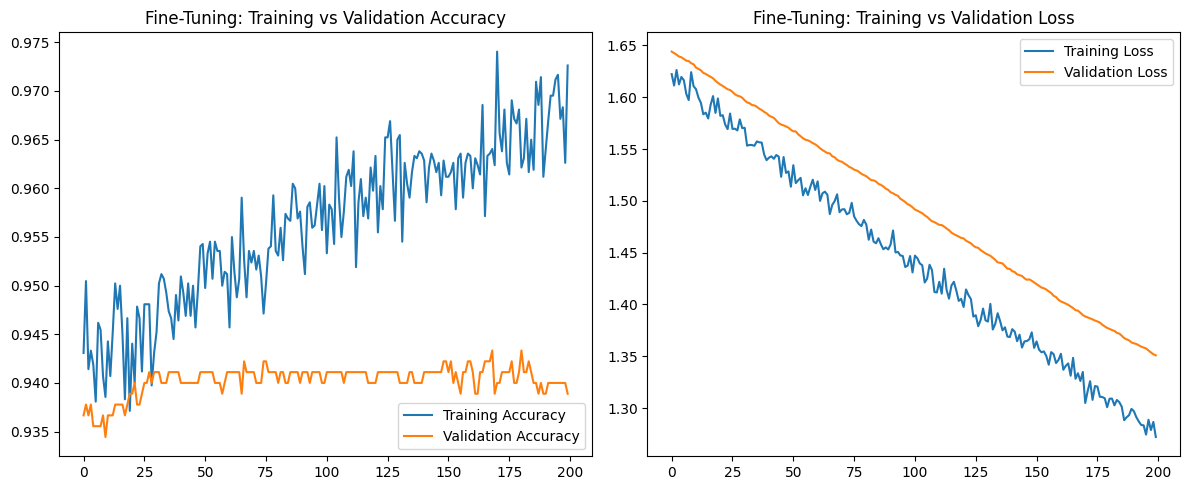

In [11]:
import matplotlib.pyplot as plt

# Extract history
acc = history_continued.history['accuracy']
val_acc = history_continued.history['val_accuracy']
loss = history_continued.history['loss']
val_loss = history_continued.history['val_loss']

epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Fine-Tuning: Training vs Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Fine-Tuning: Training vs Validation Loss')

plt.tight_layout()
plt.show()


# save Model

In [ ]:
model.save('final_mobilenetv3_mmodel/odel.h5')

In [39]:
from tensorflow.keras.models import load_model

model = load_model('best_mobilenetv3_model.h5')

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 900 images belonging to 3 classes.


29/29 [==============================] - 28s 944ms/step
Accuracy: 95.67%


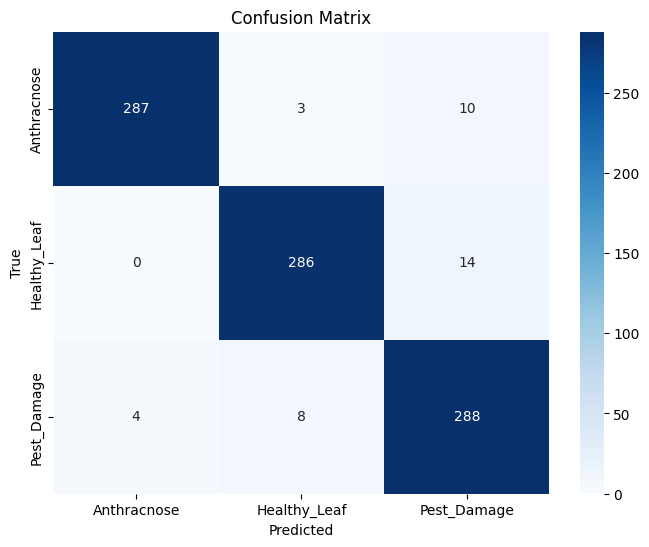

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes


accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(y_pred)

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 1 1 2 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [22]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

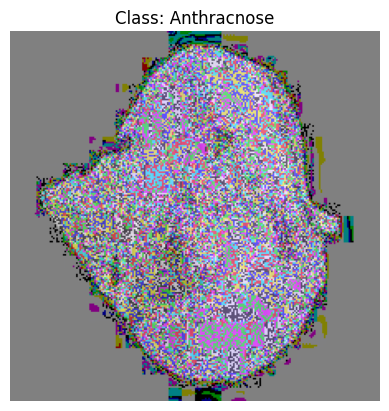

In [47]:
# Get first batch (images and labels)
images, labels = val_generator[1]  # batch index 0

# Get first image and its one-hot label
first_image = images[1]
first_label = labels[1]

# Decode label (if needed)
import numpy as np
class_indices = val_generator.class_indices
class_names = list(class_indices.keys())
decoded_label = class_names[np.argmax(first_label)]

# Plot
import matplotlib.pyplot as plt

plt.imshow((first_image * 127.5 + 127.5).astype("uint8"))  # unnormalize from [-1,1] if using MobileNetV3
plt.title(f"Class: {decoded_label}")
plt.axis('off')
plt.show()


In [60]:
images, _ = val_generator[6]  # Get only the inputs (X), ignore labels (y)
y_pred_prob = model.predict(images, verbose=1)

y_pred = np.argmax(y_pred_prob, axis=1)

print(y_pred)

1/1 [==============================] - 0s 32ms/step
[2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [61]:
image = images[6]
image = np.expand_dims(image, axis=0)  # Add batch dimension

pred_prob = model.predict(image)
pred_class = np.argmax(pred_prob)

print(f"Predicted class index: {pred_class}")


1/1 [==============================] - 0s 32ms/step
Predicted class index: 0


Found 6 images belonging to 1 classes.
6/6 [==============================] - 1s 15ms/step


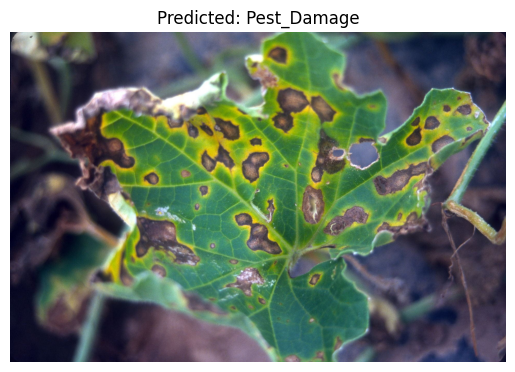

In [118]:
# 1. Load your best model (same as before)
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall

model = load_model(
    'best_mobilenetv3_model.h5',
    custom_objects={'Precision': Precision, 'Recall': Recall}
)

# 2. Use the same preprocessing pipeline as val_generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 3. Load the image using flow_from_directory
test_dir = r'D:/Senior_WorkTable/Customtest'  # Path to the folder you created

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,       # No labels required
    shuffle=True
)

# 4. Make prediction
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
predicted_index = np.argmax(predictions[0])  # first image only

# Use the same label map from val_generator
class_names = list(val_generator.class_indices.keys())
predicted_class = class_names[predicted_index]

# 5. Show result
img_path = test_generator.filepaths[4]  # first image file path
img = plt.imread(img_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()
